# 2. Probability Distributions


### *Table of Contents*

* 2.1 [Binary Variables](#2.1-Binary-Variables)
    * 2.1.1 [The Beta Distribution](#2.1.1-The-beta-distribution)
* 2.2 [Multinomial Variables](#2.2-Multinomial-Variables)
    * 2.2.1 [The Dirichlet Distribution](#2.2.1-The-Dirichlet-distribution)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from prml.distribution import (
    Bernoulli,
    Binomial,
    Beta,
    Dirichlet,
    MultivariateGaussian
)

# Set random seed to make deterministic
np.random.seed(0)

## 2.1 Binary Variables

Consider a single binary random variable $x \in \{0, 1\}$, for instance $x$ might be the outcome of flipping a coin. Then, the probability of heads ($x=1$) can be denoted by a parameter $\mu$ so that,

$$
p(x=1|\mu) = \mu
$$

where $0 \leq \mu \leq 1$. The *Bernoulli* probability distribution over $x$ has therefore the form,

$$
\text{Bern}(x|\mu) = \mu^x(1-\mu)^{1-x}
$$

It is easily verified that the Bernoulli distribution has mean given by,

$$
\mathbb{E}[x] = \sum_{x \in \{0, 1\}} x\text{Bern}(x|\mu) =
\sum_{x \in \{0, 1\}} x\mu^x(1-\mu)^{1-x} =
\mu^1(1-\mu)^0 =
\mu
$$

and variance given by,

$$
\begin{align*}
\text{var}[x] &= \mathbb{E}[x]^2 - \mathbb{E}[x^2] \\
&= \mu^2 - \sum_{x \in \{0, 1\}} x^2\text{Bern}(x|\mu) \\
&= \mu^2 - \sum_{x \in \{0, 1\}} x^2\mu^x(1-\mu)^{1-x} \\
&= \mu^2 - \mu = \mu(\mu - 1)
\end{align*}
$$

Now suppose we have given a data set $\mathcal{D} = \{x_1,\dots,x_N\}$ of observed values sampled from an **unknown** Bernoulli distribution (outcomes of coin tosses), that is, the $\mu$ parameter (probability of heads) is unknown.

Fair coin   --  Heads: 51 Tails: 49
Biased coin --  Heads: 16 Tails: 84


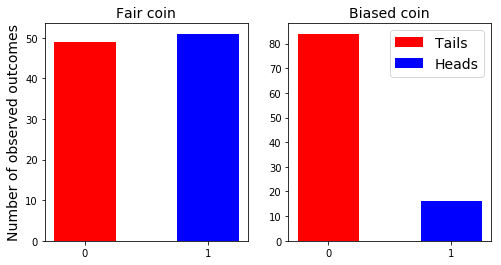

In [2]:
# For demonstration purposes we shall create a data set from a fair coin (mu = 0.5)
# and another data set from a biased coin favoring tails (mu = 0.2).

# Number of coin tosses per data set
N = 100

# Fair coin
mu_fair = 0.5
true_distribution_fair = Bernoulli(mu_fair)
D_fair = true_distribution_fair.draw(N)

print("Fair coin   -- ", "Heads:", sum(D_fair == 1), "Tails:", sum(D_fair == 0))

# Biased coin
mu_biased = 0.2
true_distribution_biased = Bernoulli(mu_biased)
D_biased = true_distribution_biased.draw(N)

print("Biased coin -- ", "Heads:", sum(D_biased == 1), "Tails:", sum(D_biased == 0))

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
b = plt.bar([0,1], [sum(D_fair == 0), sum(D_fair == 1)], color=['red','blue'], width=0.5)
b[0].set_label("Tails")
b[1].set_label("Heads")
plt.ylabel("Number of observed outcomes", fontsize=14)
plt.xticks([0, 1])
plt.title("Fair coin", fontsize=14)

plt.subplot(1,2,2)
b = plt.bar([0,1], [sum(D_biased == 0), sum(D_biased == 1)], color=['red','blue'], width=0.5)
b[0].set_label("Tails")
b[1].set_label("Heads")
plt.xticks([0, 1])
plt.title("Biased coin", fontsize=14)
plt.legend(fontsize=14)

plt.show()

We can use the likelihood function on the assumption that the observations are drawn independently from $\text{Bern}(x|\mu)$, so that,

$$
p(\mathcal{D}|\mu) = \prod_{n=1}^N \text{Bern}(x_n|\mu) = \prod_{n=1}^N \mu^{x_n}(1-\mu)^{1-x_n}
$$

Then, following the frequentist approach, we can estimate the value of $\mu$ by maximizing the logarithm of the likelihood given by

$$
\begin{align*}
\ln p(\mathcal{D}|\mu) &= \ln \bigg( \prod_{n=1}^N \mu^{x_n}(1-\mu)^{1-x_n} \bigg) \\
&= \sum_{n=1}^N \ln \big( \mu^{x_n}(1-\mu)^{1-x_n} \big) \\
&= \sum_{n=1}^N \bigg( \ln \big( \mu^{x_n} \big) + \ln \big( (1-\mu)^{1-x_n} \big) \bigg) \\
&= \sum_{n=1}^N \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) 
\end{align*}
$$

Given an observed data set $\mathcal{D}$, we can plot the value of the log-likelihood against the values of $\mu \in [0,1]$.

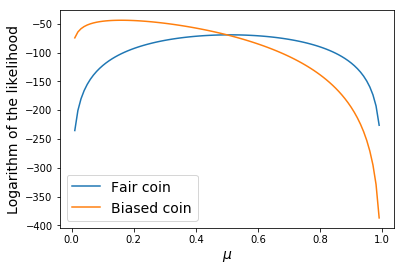

In [3]:
mu_space = np.arange(0.01, 1, 0.01)
ll = np.zeros(mu_space.shape)

for i, mu_i  in enumerate(mu_space):
    ll[i] = Bernoulli(mu_i).log_likelihood_iid(D_fair)

plt.plot(mu_space, ll, label="Fair coin")

for i, mu_i  in enumerate(mu_space):
    ll[i] = Bernoulli(mu_i).log_likelihood_iid(D_biased)

plt.plot(mu_space, ll, label="Biased coin")

plt.xlabel("$\mu$", fontsize=14); plt.ylabel("Logarithm of the likelihood", fontsize=14)
plt.legend(fontsize=14); plt.show()

Note that the **maximum** of the likelihood is achieved around $\mu=0.5$ for the fair coin and $\mu=0.2$ for the biased coin. Therefore, using calculus, if we set the derivative of $\ln p(\mathcal{D}|\mu)$ with respect to $\mu$ equal to zero, we obtain

$$
\begin{align*}
&\frac{\partial}{\partial\mu} \ln p(\mathcal{D}|\mu) = 0 \Leftrightarrow \\
&\frac{\partial}{\partial\mu} \sum_{n=1}^N \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \frac{\partial}{\partial\mu} \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n - \frac{1}{1 - \mu}(1-x_n) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n - \frac{1}{1 - \mu} + \frac{1}{1 - \mu}x_n \bigg) = 0\Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n + \frac{1}{1 - \mu}x_n \bigg) = \frac{N}{1 - \mu} \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1 - \mu}{\mu}x_n + x_n \bigg) = N \Leftrightarrow \\
&\sum_{n=1}^N \frac{1}{\mu}x_n = N \Leftrightarrow \\
&\mu_{ML} = \frac{1}{N}\sum_{n=1}^N x_n
\end{align*}
$$

which is known as the *sample mean*. Thus, the probability of landing heads ($\mu$), according to the maximum likelihood estimator, is given by the fraction of observations of heads in the data set $\mathcal{D}$. Indeed caclulating the sample mean gives us a very accurate estimation of the true values for $\mu$.

In [4]:
print("Maximum likelihood 𝜇 for the fair coin is", sum(D_fair == 1) / N)
print("Maximum likelihood 𝜇 for the biased coin is", sum(D_biased == 1) / N)

Maximum likelihood 𝜇 for the fair coin is 0.51
Maximum likelihood 𝜇 for the biased coin is 0.16


However, A problem that arises from this result is that for small data sets the estimation can be unreasonable. For instance, in the following plot, note that for small data sets $N < 100$, the estimated $\mu_{\text{ML}}$ can deviate significantly from the true $\mu$ leading to incorrect probabilities for the future observations.

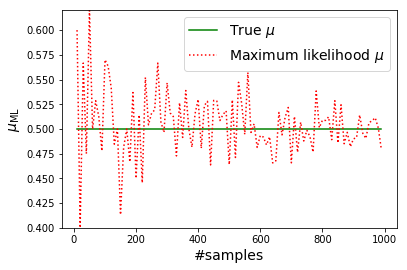

In [5]:
ml_model = Bernoulli()
samples = list(range(10, 1000, 10))
mu_estimations = []

for N in samples:
    D = true_distribution_fair.draw(N)
    ml_model.ml(D)
    mu_estimations.append(ml_model.mu)
    
plt.plot(samples, [mu_fair for N in samples], color="g", label="True $\mu$")
plt.plot(samples, mu_estimations, color="r", linestyle=":", label="Maximum likelihood $\mu$")
plt.xlabel("#samples", fontsize=14); plt.ylabel("$\mu_{\mathrm{ML}}$", fontsize=14)
plt.ylim([min(mu_estimations), max(mu_estimations)])
plt.legend(fontsize=14); plt.show()

Now, if we toss a coin $5$ times, then, the probability of getting $3$ heads and then $2$ tails is

$$
p(x_1=1)p(x_2=1)p(x_3=1)p(x_4=0)p(x_5=0) = \mu \times \mu \times \mu \times (1 - \mu) \times (1 - \mu)
$$

or more general for $N$ times and $m$ heads, 

$$
\mu^m(1-\mu)^{N-m}
$$

However, this is just one way to get $m$ heads, there are many other sequences of $N$ trials that would give us $m$ heads. How many exactly?

The distribution describing the number of $m$ observations of $x=1$ in a sample dataset of size $N$ is called the [*Binomial* distribution](https://www.youtube.com/watch?v=8idr1WZ1A7Q), and is given by

$$
\text{Bin}(m|N,\mu) = 
\left(\!
    \begin{array}{c}
      N \\
      m
    \end{array}
\!\right)
\mu^m(1 - \mu)^{N-m}
$$

where

$$
\left(\!
    \begin{array}{c}
      N \\
      m
    \end{array}
\!\right)
= \frac{N!}{(N-m)!m!}
$$

is the numbers of ways of choosing $m$ objects out of a total of $N$ identical objects, and is called the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient).

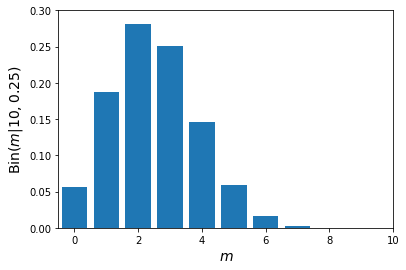

In [6]:
model = Binomial(10, 0.25)
y = model.pdf(np.arange(0, 10))

plt.bar(np.arange(0, 10), y)
plt.xlim([-0.5, 10]); plt.ylim([0, 0.3])
plt.xlabel("$m$", fontsize=14); plt.ylabel("$\mathrm{Bin}(m|10,0.25)$", fontsize=14)
plt.show()

### 2.1.1 The beta distribution

We have seen that the maximum likelihood estimator for the parameter $\mu$ in the Bernoulli and binomial distributions, is given by the fraction of the observations in the data having $x=1$, which can lead to over-fitted results for small data sets. In order to arrive to more sensible results, we develop a **Bayesian treatment** for the problem by introducing a prior distribution $p(\mu)$ over the parameter $\mu$.

Note that the likelihood function takes the form of the product of factors of the form $\mu^x(1-\mu)^{(1-x)}$. We would like to choose a prior proportional to powers of $\mu$ and $(1-\mu)$ in order for the posterior to have the same functional form as the prior, since the posterior is proportional to the product of the prior and the likelihood. This important property is called **conjugacy**.

We therefore we choose a prior, called the **beta** distribution, given by

$$
\text{Beta}(\mu|a,b) = \frac{\Gamma(a + b)}{\Gamma(a)\Gamma(b)} \mu^{a-1}(1-\mu)^{b-1}
$$

where $a$ and $b$ are often called hyperparameters because they control the distribution of the parameter $\mu$. In order to give an intuition about the hyperparameteres, we plot the beta distribution for various values of $a$ and $b$.

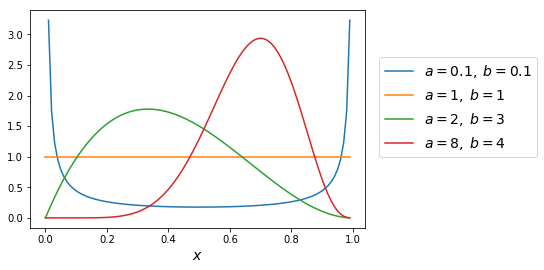

In [21]:
x_space = np.arange(0, 1, 0.01)

for a, b in [(0.1, 0.1), (1, 1), (2, 3), (8, 4)]:
    model = Beta(a, b)
    plt.plot(x_space, model.pdf(x_space), label="$a={},\; b={}$".format(a, b))

plt.xlabel("$x$", fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.85), loc=2, borderaxespad=1, fontsize=14); plt.show()

The fraction of $\Gamma(x)$ functions ensures that the beta distribution is normalized, so that

$$
\int_0^1 \text{Beta}(\mu|a,b)d\mu = 1
$$

The mean is given by

$$
\begin{align*}
\mathbb{E}[\mu] &= \int_0^1 \mu\text{Beta}(\mu|a,b)d\mu \\
&= \int_0^1 \mu\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \mu^{a-1}(1-\mu)^{b-1} d\mu \\
&= \int_0^1 \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \int_0^1 \frac{a\Gamma(a+b+1)}{(a+b)\Gamma(a+1)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \frac{a}{a+b}\int_0^1 \frac{\Gamma(a+b+1)}{\Gamma(a+1)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \frac{a}{a+b}\int_0^1 \text{Beta}(\mu|a+1,b)d\mu \\
&= \frac{a}{a+b}
\end{align*}
$$

where we have taken advantage of the property $\Gamma(x+1)=x\Gamma(x)$. The variance is given by

$$
\text{var}[\mu] = \frac{ab}{(a+b)^2(a+b+1)}
$$

The posterior distribution over $\mu$ can be obtained by multiplying the beta prior by the binomial likelihood function,

$$
p(\mu|m,l,a,b) = \text{Bin}(m|N,\mu)\text{Beta}(\mu|a,b) = 
\frac{\Gamma(m+a+l+b)}{\Gamma(m+a)\Gamma(l+b)} \mu^{m+a-1}(1-\mu)^{l+b-1}
$$

where $l=N-m$, and corresponds to the number of times $x=0$.

Note that the effect of observing a data set of $m$ observations of $x=1$ and $l$ observations of $x=0$ is to  increase the value of $a$ by $m$, and the value of $b$ by $l$, from the prior to the posterior distribution. Thus, the hyperparameters $a$ and $b$ in the prior represent the number of observations of $x=1$ and $x=0$, respectively. Furthermore, the posterior distribution can act as the prior if subsequent observations arrive. Imagine taking one observation at a time and after each observation updating the current posterior distribution by multiplying by the likelihood of the incoming observation. At each stage, the posterior is a beta distribution incorporating some number of (prior and actual) observed values for $x=1$ and $x=0$ given by the parameters $a$ and $b$. Incorporation an additional observation of $x=1$ corresponds to incrementing the value of $a$ by $1$, whereas for $x=0$ increment $b$ by $1$.

We present a sequence of such Bayesian inference steps, where three observations of $x=1$ arrive before a single observation of $x=0$. Note how the prior revises the form of the posterior on each update step according to the likelihood. Apart from the first step, where the prior is a Beta distribution having paramater $a=2$ and $b=2$, in each subsequent step the prior is the posterior of the previous step.

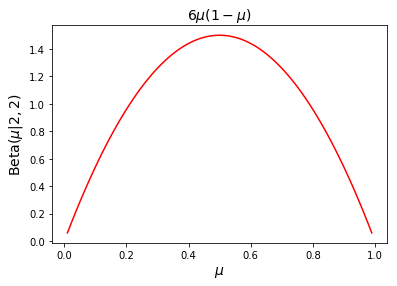

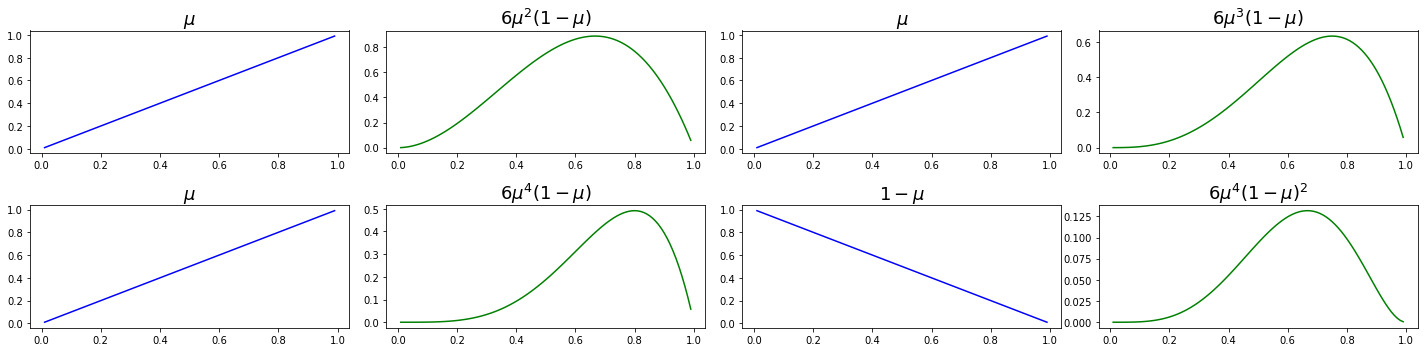

In [19]:
# The Beta conjugate prior for the Binomial distribution (starting parameter a=2, b=2)
prior = Beta(a=2, b=2)
plt.plot(mu_space, prior.pdf(mu_space), color='red')
plt.xlabel('$\mu$', fontsize=14); plt.ylabel('$\mathrm{Beta}(\mu|2,2)$', fontsize=14)
plt.title(prior.change_notation({'x': 'mu'}).to_latex, fontsize=14)
plt.show()

# Apply a sequence of Bayesian inference steps, as more observations arrive in the form of a likelihood
plt.figure(figsize=(20, 5))

# Row 1
plt.subplot(2,4,1)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,2)
plt.tight_layout()
posterior = prior.change_notation({'x': 'mu'}) * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.subplot(2,4,3)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,4)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

# Row 2
plt.subplot(2,4,5)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,6)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.subplot(2,4,7)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(0)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,8)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.show()

Thus, the **sequential** approach to learning arises naturally when we adopt a Bayesian viewpoint. It is **independent** of the choice of prior and of the likelihood function and **depends only** on the assumption of i.i.d. data. Sequential methods make use of observations one at a time, or in small batches, and then discard them before the next observations are used. They can be used, for example, in real-time learning scenarios where a steady stream of data is arriving, and predictions must be made before all of the data is seen. Maximum likelihood methods can also be cast into a sequential framework.

If our goal is to predict the outcome fo the next trial, then we must evaluate the predictive distribution of $x$ given the observed data $\mathcal{D}$ given by,

$$
p(x=1|\mathcal{D}) = \frac{m + a}{m + a + l + b}
$$

which essentially represents the fraction of observations (actual and prior) that corresponds to $x=1$. Note that in the limit of an infinitely large data set $m,l \to \infty$, $p(x=1|\mathcal{D})$ reduces to the maximum likelihood estimator $\frac{m}{N}$. 

It is a very **general property** that the Bayesian and maximum likelihood results are identical in the limit of infinitely large data sets. For finite data set, the posterior mean for $\mu$ always lies between the prior mean and the maximum likelihood estimate for $\mu$, corresponding to the sample mean.

## 2.2 Multinomial Variables

Apart from binary random variables, some discrete random variables can take on one of $K$ possible mutually exclusive states of the form

$$
\mathbf{x} = (0,0,1,0,0,0)^{\text{T}}
$$

If we denote the probability of $x_k=1$ by the parameter $\mu_k$, then the distribution over $\mathbf{x}$ is given by

$$
p(\mathbf{x}|\mathbf{\mu}) = \prod_{k=1}^K \mu_k^{x_k}
$$

where the parameters $\mathbf{x} = (\mu_1,\dots\mu_K)^{\text{T}}$ must satisfy $\mu_k \geq 0$ and $\sum_k \mu_k = 1$ because they represent probabilities. The distribution can be regarded as a generalization of the Bernoulli distribution for more than two outcomes.

### 2.2.1 The Dirichlet distribution